In [239]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
from PIL import Image
%matplotlib inline

In [414]:
class Network(object):
    
    def __init__(self, layer_node): #layer_node is a list contains the number of nodes in each layer
        self.num_layer = len(layer_node)
        self.layer_node = layer_node
        self.input_node = []
        #self.node = [ np.random.randn(num_node,1) for num_node in layer_node ]
        self.weights = [ np.random.randn(next_node,previous_node+1) for next_node, previous_node in zip(layer_node[1:],layer_node[:-1]) ]
        
    def add_input_node(self,input_vector): #must be of size (n,1)
        if len(input_vector) == self.layer_node[0]: 
            self.input_node = np.append([[1]],input_vector, axis=0) # add bias node
        else:
            print "Input vector length invalid: given len {1}, need len {0}".format(self.layer_node[0], len(input_vector))
            
    def forward_propagation(self):
        output_vector = self.input_node
        for weight in self.weights: 
            #print weight.shape
            #print output_vector.shape
            s = np.dot(weight, output_vector)
            output_vector = np.append([[1]], output_transformation(s), axis=0) # add bias node -> size (n+1,1)
        return output_vector[1:] # we omit the bias node 
        
    def backpropagation(self,input_vector, output_vector):
        s = [] # vector before entering node
        x = [np.append([[1]],input_vector, axis=0)] # vector after entering node
        sensitivity = [ np.zeros([1,i]) for i in self.layer_node[1:] ]
        #print len(sensitivity)
        
        #feedforward, save all the node coefs of each layer
        for weight in self.weights:
            s.append(np.dot(weight, x[-1]))
            x.append(np.append([[1]], output_transformation(s[-1]), axis=0))
            
        sensitivity[-1] = 2*(x[-1][1:] - output_vector) # omit the bias node 
        
        #backpropagation, compute sensitivity backward
        for layer_index in xrange(2, self.num_layer):
            w = self.weights[-layer_index+1]
            #print w
            #print w.shape
            #print sensitivity[-layer_index+1].shape
            
            sensitivity[-layer_index] = (np.dot(w.T,sensitivity[-layer_index+1]))[1:] #excluding the bias componnent which has the index 0
            
        return x, sensitivity
    
    def SGD(self, training_data, testing_data, eta, epochs): #stochastic gradient descent
        MSE_list = []
        predicted_result = []
        for epoch in xrange(epochs): 
            MSE = 0 
            gradient = [ np.random.randn(next_node,previous_node+1) 
                            for next_node, previous_node in zip(self.layer_node[1:],self.layer_node[:-1])]
            for index, row in training_data.iterrows():
                vector = np.array(row).reshape(3,1) 
                input_vector, output_vector = vector[:2], vector[2:]
                x, sensitivity = self.backpropagation(input_vector, output_vector)
                #gradient = [ np.random.randn(next_node,previous_node+1) 
                            #for next_node, previous_node in zip(self.layer_node[1:],self.layer_node[:-1])]
                for l in xrange(len(gradient)):
                    #print x[l].shape
                    #print sensitivity[l].shape
                    gradient[l] = np.dot(sensitivity[l],np.transpose(x[l]))
                    self.weights[l] = self.weights[l] - eta*gradient[l]
            MSE, predicted_result = self.evaluate(testing_data)
            MSE_list.append(MSE)
            #print "Epoch {0}: MSE = {1}".format(epoch+1, MSE)
            #print
        return MSE_list, predicted_result
    
    
    
    def evaluate(self,testing_data):
        MSE = 0
        predicted_result = []
        for index, row in testing_data.iterrows():
            vector = np.array(row).reshape(3,1) 
            input_vector, output_vector = vector[:2], vector[2:]
            self.add_input_node(input_vector)
            predicted_vector = self.forward_propagation()
            predicted_result.append(predicted_vector[0,0])
            #print predicted_vector, output_vector
            MSE += np.abs(predicted_vector - output_vector)
        return MSE[0][0]/testing_data.shape[0], predicted_result

            

In [415]:
def output_transformation(z):
    return z # linear regression -> identity function

In [416]:
data = pd.read_csv('donneespb3.txt', sep=' ', header=None)

In [417]:
data.columns = ['x','y','z']

In [418]:
data.head()

,x,y,z
0,"334,783210575014","454,948964740592","0,00222160492674384"
1,"111,777755949543","258,571017886778","0,799073240401644"
2,"267,262460555538","378,948263069125","0,609963894856347"
3,"237,746752443605","39,6912645267748","0,0524955007232427"
4,"411,91052687909","360,973760653741","0,31001280464793"


In [419]:
def str_to_float(df): 
    new_df = df.copy()
    return new_df.applymap(lambda x: float(x.replace(',','.')))

In [420]:
data = str_to_float(data)

In [421]:
data.describe()

,x,y,z
count,3000.000000,3000.000000,3000.000000
mean,250.070525,247.538214,0.473798
std,143.558329,144.776419,0.350761
min,0.003081,0.047071,0.000010
25%,127.154623,122.687177,0.127083
50%,254.268244,248.545446,0.441669
75%,372.184817,373.087591,0.825775
max,499.521608,499.940887,0.999990


In [422]:
def normalize(df): 
    new_df = df.copy()
    new_df[['x','y']] = new_df[['x','y']] / 500
    return new_df

In [423]:
data = normalize(data)
data.describe()

,x,y,z
count,3000.000000,3000.000000,3000.000000
mean,0.500141,0.495076,0.473798
std,0.287117,0.289553,0.350761
min,0.000006,0.000094,0.000010
25%,0.254309,0.245374,0.127083
50%,0.508536,0.497091,0.441669
75%,0.744370,0.746175,0.825775
max,0.999043,0.999882,0.999990


In [504]:
test = data.iloc[:]

In [450]:
train = data.iloc[:2700]
train.shape

(2700, 3)

In [451]:
test = data.iloc[2700:]
test.shape

(300, 3)

In [505]:
neural_net = Network([2,40,1])

In [506]:
MSE, predicted_result = neural_net.SGD(training_data = test, testing_data = test, eta = 0.01, epochs = 10000)

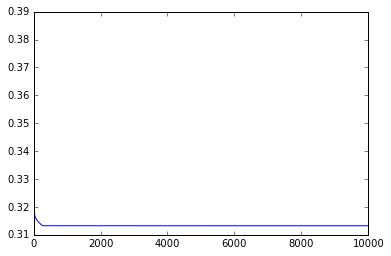

In [507]:
plt.plot(MSE)

In [508]:
t = test.copy()

In [509]:
t['Predicted'] = predicted_result

In [510]:
t.head()

,x,y,z,Predicted
0,0.669566,0.909898,0.002222,0.438261
1,0.223556,0.517142,0.799073,0.438453
2,0.534525,0.757897,0.609964,0.438327
3,0.475494,0.079383,0.052496,0.438503
4,0.823821,0.721948,0.310013,0.438272


In [511]:
t.describe()

,x,y,z,Predicted
count,3000.000000,3000.000000,3000.000000,3000.000000
mean,0.500141,0.495076,0.473798,0.438398
std,0.287117,0.289553,0.350761,0.000094
min,0.000006,0.000094,0.000010,0.438168
25%,0.254309,0.245374,0.127083,0.438330
50%,0.508536,0.497091,0.441669,0.438398
75%,0.744370,0.746175,0.825775,0.438465
max,0.999043,0.999882,0.999990,0.438625


In [512]:
def convert_to_pixel(oldValue):
    oldRange = 1 
    newRange = 255 
    newValue = (((oldValue - 0) * newRange) / oldRange) + 0 #oldMin = newMin = 0
    return math.ceil(newValue)

In [513]:
new_z = t['z'].apply(convert_to_pixel)
new_predicted = t['Predicted'].apply(convert_to_pixel)

In [514]:
t.z = new_z
t.Predicted = new_predicted
t.head()

,x,y,z,Predicted
0,0.669566,0.909898,1,112
1,0.223556,0.517142,204,112
2,0.534525,0.757897,156,112
3,0.475494,0.079383,14,112
4,0.823821,0.721948,80,112


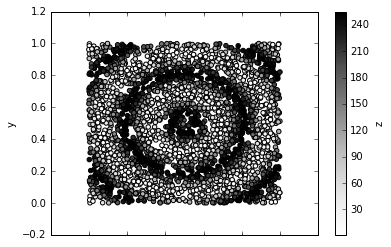

In [515]:
t.plot(kind='scatter',x='x',y='y',c='z')

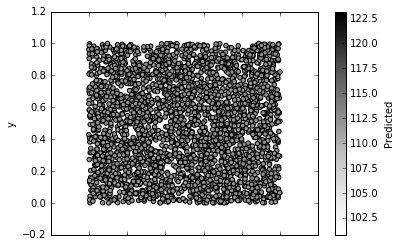

In [516]:
t.plot(kind='scatter',x='x',y='y',c='Predicted')